In [16]:
import numpy as np

# Define the unitary S matrix
S = np.exp(1j*np.pi/2)*np.array([[0, 1],
              [1, 0]])

# Construct the real symplectic matrix
ReS = S.real
ImS = S.imag
F = np.block([[ReS, -ImS],
                   [ImS,  ReS]])

# Define Omega for 2 modes
J = np.array([[0, 1],
              [-1, 0]])
Omega = np.block([[J, np.zeros((2, 2))],
                  [np.zeros((2, 2)), J]])

# Compute S_symp * Omega * S_symp.T
check = F @ Omega @ F.T

# Compare with Omega
print("S_symp * Omega * S_symp.T =\n", check)
print("Is symplectic?", np.allclose(check, Omega))
print("Is anti-symplectic?", np.allclose(check, -Omega))


S_symp * Omega * S_symp.T =
 [[ 0. -1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]]
Is symplectic? False
Is anti-symplectic? True


In [11]:
F.T @ Omega @ F

array([[ 0., -1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.],
       [ 0.,  0.,  1.,  0.]])

In [16]:
from qutip import basis, tensor

# Vacuum in mode a
vac_a = basis(3, 1)

# Single photon in mode b
one_b = basis(3, 1)

# Tensor product state |0>_a ⊗ |1>_b
state = tensor(vac_a, one_b)
state

Quantum object: dims=[[3, 3], [1]], shape=(9, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [44]:
import numpy as np
from scipy.special import hermite
from scipy.integrate import simpson
import math

def hermite_gauss_mode(n, t, w0=1.0):
    """
    Generate the n-th order Hermite-Gaussian mode evaluated at times t.
    w0 is the waist parameter controlling the width.
    """
    Hn = hermite(n)
    norm = (2**n * math.factorial(n) * np.sqrt(np.pi) * w0)**(-0.5)
    xi = np.sqrt(2) * t / w0
    mode = norm * Hn(xi) * np.exp(-xi**2 / 2)
    return mode

def normalize_mode(f, t):
    """
    Normalize mode vector f sampled at times t using trapezoidal integration.
    """
    norm = np.sqrt(simpson(np.abs(f)**2, t))
    return f / norm

def single_to_multi_mode(mean_f, cov_f, f):
    """
    Convert single mode mean and covariance to multi-mode in delta basis.
    mean_f: (2,) array, [q_mean, p_mean]
    cov_f: (2,2) covariance matrix for single mode
    f: (M,) real mode vector, normalized
    Returns:
      mean_multi: (2*M,) vector
      cov_multi: (2*M, 2*M) covariance matrix
    """
    M = len(f)
    # Create S = f as column vector (M x 1)
    S = f.reshape(M, 1)

    # Identity in quadrature space (2x2)
    I2 = np.eye(2)

    # Mean multi = kron(S, I2) @ mean_f
    mean_multi = np.kron(S, I2) @ mean_f  # shape (2*M,)

    # Covariance multi = kron(S, I2) @ cov_f @ kron(S, I2).T
    kron_S_I2 = np.kron(S, I2)  # shape (2*M, 2)
    cov_multi = kron_S_I2 @ cov_f @ kron_S_I2.T  # shape (2*M, 2*M)

    return mean_multi, cov_multi

# Example usage:

# Time grid
M = 200
t = np.linspace(-5, 5, M)

# Generate 3rd order Hermite-Gaussian mode
n = 3
f = hermite_gauss_mode(n, t, w0=1.0)
f = normalize_mode(f, t)

# Define single-mode Gaussian state parameters (q,p means and covariance)
mean_f = np.array([0.3, -0.6])  # example mean quadratures
cov_f = np.array([[1.2, 0.1],
                  [0.1, 0.8]])  # example covariance matrix (should be positive definite)

# Convert to multi-mode in delta basis
mean_multi, cov_multi = single_to_multi_mode(mean_f, cov_f, f)

print("Multi-mode mean vector shape:", mean_multi.shape)  # Expect (2*M,)
print("Multi-mode covariance matrix shape:", cov_multi.shape)  # Expect (2*M, 2*M)


Multi-mode mean vector shape: (400,)
Multi-mode covariance matrix shape: (400, 400)


In [45]:
np.trace(cov_multi)

np.float64(39.80000000000001)

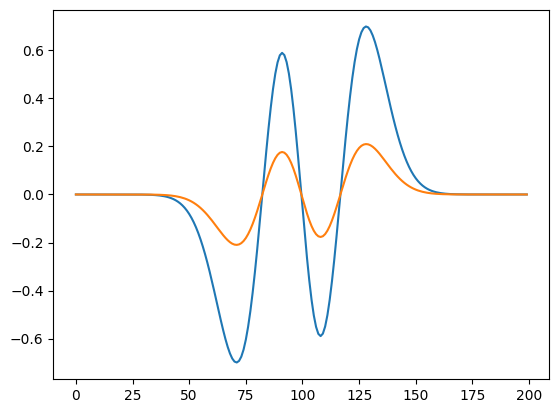

In [39]:
import matplotlib.pyplot as plt
plt.plot(f)
plt.plot(mean_multi[::2])

In [ ]:
import jax
import jax.numpy as jnp
from scipy.constants import epsilon_0, Boltzmann

h_bar = 0.5

def annihilation_operator(N_max=10, f=1, t=0):
    a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)
    for n in range(1, N_max):
        a = a.at[n-1, n].set(jnp.sqrt(n))

    return a

def electric_field_operator(N_max=10, f=1, t=0, mode_volume=1):
    E_0 = jnp.sqrt((h_bar*2*jnp.pi*f)/(epsilon_0*mode_volume))
    E_0 = 1
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    
    return E_0 * (a + a_dagger)

def number_operator(N_max, f=1.0, t=0):
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    return a_dagger@a

def expectation_value_pure(operator, psi):
    return jnp.vdot(psi, operator@psi)

def expectation_value_mixed(operator, rho):
    return jnp.trace(rho@operator)

def thermal_state(N_max, f=1.0, temperature=1/Boltzmann):
    n = jnp.arange(0, N_max)
    E_n = h_bar*2*jnp.pi*f*(n+0.5)
    
    P_n = jnp.exp(-E_n / (Boltzmann*temperature))
    P_n = P_n / jnp.sum(P_n)
    return jnp.diag(P_n)

def coherent_state(alpha, N_max=10, f=1.0):
    n = jnp.arange(0, N_max)
    return jnp.exp(-0.5*jnp.abs(alpha)**2) * alpha**n / jnp.sqrt(jax.scipy.special.factorial(n))

def vacuum_state(N_max=10, f=1.0):
    vac = jnp.zeros(N_max, dtype=jnp.complex128)
    vac = vac.at[0].set(1.0)
    return vac

def displacement_operator(alpha, N_max=10, f=1.0, t=0):
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    return jax.scipy.linalg.expm(alpha*a_dagger - jnp.conj(alpha)*a)

def characteristic_function_mixed(rho, f=1.0, t=0):
    N_max = rho.shape[0]

    def characteristic_fn(eta):
        return jnp.trace(rho @ displacement_operator(eta, N_max=N_max, f=f, t=t))

    def apply_fn(eta_grid):  # eta_grid shape: (N, M)
        flat_eta = eta_grid.reshape(-1)

        def scan_fn(carry, eta):
            val = characteristic_fn(eta)
            return carry, val

        # remat helps prevent backprop memory buildup
        _, results = jax.lax.scan(jax.remat(scan_fn), None, flat_eta)
        return results.reshape(eta_grid.shape)

    return apply_fn

def characteristic_function_pure(psi, f=1.0, t=0):
    rho = jnp.outer(psi, psi.conj().T)
    N_max = rho.shape[0]
    
    return characteristic_function_mixed(rho, f=f, t=t)

def characteristic_function_gaussian(mean, covariance):
    def characteristic_fn(eta):
        xi = jnp.sqrt(2) * jnp.array([jnp.real(eta), jnp.imag(eta)])
        return jax.scipy.linalg.expm(-0.5*xi@covariance@eta + 1j*mean@xi)
    
    return characteristic_fn

def eigenvalue_from_vector(A, v):
    Av = A @ v
    # Normalize vector to unit norm to avoid scaling ambiguity
    v_normalized = v / jnp.linalg.norm(v)
    return jnp.vdot(v_normalized, Av)  # = λ if v is an eigenvector

def wigner_function(alpha, characteristic_fn, grid_size=80, limit=4.0):
    dx = 2 * limit / grid_size
    x = jnp.linspace(-limit, limit, grid_size)
    y = jnp.linspace(-limit, limit, grid_size)
    xx, yy = jnp.meshgrid(x, y)
    lam = xx + 1j * yy  # shape: (grid_size, grid_size)

    lam_flat = lam.reshape(-1)
    chi_vals = characteristic_fn(lam_flat).reshape(lam.shape)

    exponent = jnp.conj(lam) * alpha - lam * jnp.conj(alpha)
    integrand = chi_vals * jnp.exp(exponent)
    integral = jnp.sum(integrand) * dx**2

    return (1 / jnp.pi**2) * integral.real

def coherence_1(rho, t1, t2):
    N_max = rho.shape[0]
    t1 = 0
    t2 = 1
    a_hat_1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_hat_2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    denominator = jnp.sqrt(
        expectation_value_mixed(a_hat_1.conj().T @ a_hat_1, rho)
        * expectation_value_mixed(a_hat_2.conj().T @ a_hat_2, rho)
    )
    
    numerator = expectation_value_mixed(a_hat_1.conj().T @ a_hat_2, rho)

    return numerator/denominator

def coherence_2(rho, t1, t2):
    N_max = rho.shape[0]
    a_hat_1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_hat_2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    denominator = (
        expectation_value_mixed(a_hat_1.conj().T @ a_hat_1, rho)
        * expectation_value_mixed(a_hat_2.conj().T @ a_hat_2, rho)
    )

    numerator = expectation_value_mixed(a_hat_1.conj().T @ a_hat_2.conj().T @ a_hat_2 @ a_hat_1, rho)

    return numerator/denominator

In [ ]:
N_max=40
T = 1/Boltzmann
t=0
f = 1
n_hat = number_operator(N_max=N_max, f=f, t=t)
temperature = 1/Boltzmann
rho_th = thermal_state(N_max)
print(expectation_value_mixed(n_hat, rho_th))
print(1/(jnp.exp(h_bar*2*jnp.pi*f/(Boltzmann*T))-1))

(0.04516570536368411+0j)
0.04516570536368411


In [ ]:
print(coherence_1(rho_th, 0, 1))
print(coherence_2(rho_th, 0, 1))

(1+0j)
(2.000000000000001+0j)


In [16]:
vac = vacuum_state(N_max)
alpha = 0.5
print(displacement_operator(alpha, N_max=N_max) @ vac)
print(coherent_state(alpha, N_max=N_max))

[8.82496903e-01+0.j 4.41248451e-01+0.j 1.56004886e-01+0.j
 4.50347315e-02+0.j 1.12586829e-02+0.j 2.51751802e-03+0.j
 5.13886215e-04+0.j 9.71153661e-05+0.j 1.71677335e-05+0.j
 2.86128891e-06+0.j 4.52409501e-07+0.j 6.82032984e-08+0.j
 9.84429818e-09+0.j 1.36515853e-09+0.j 1.82426982e-10+0.j
 2.35512222e-11+0.j 2.94390277e-12+0.j 3.57000649e-13+0.j
 4.20729300e-14+0.j 4.82609606e-15+0.j 5.39573942e-16+0.j
 5.88723437e-17+0.j 6.27581292e-18+0.j 6.54298728e-19+0.j
 6.67790841e-20+0.j 6.67790821e-21+0.j 6.54822716e-22+0.j
 6.30103640e-23+0.j 5.95394198e-24+0.j 5.52817858e-25+0.j
 5.04654817e-26+0.j 4.53061072e-27+0.j 3.99586815e-28+0.j
 3.44653150e-29+0.j 2.89817949e-30+0.j 2.58393835e-31+0.j
 3.96946964e-32+0.j 1.36836821e-32+0.j 5.66449196e-33+0.j
 2.15406154e-33+0.j 7.38414054e-34+0.j 2.31739718e-34+0.j
 6.75588000e-35+0.j 1.84958640e-35+0.j 4.79404612e-36+0.j
 1.18376775e-36+0.j 2.79836111e-37+0.j 6.35840412e-38+0.j
 1.39327902e-38+0.j 2.95248758e-39+0.j 6.06510437e-40+0.j
 1.21029292e-4

In [17]:
a_hat = annihilation_operator(N_max=N_max, f=f, t=t)
print(eigenvalue_from_vector(a_hat, coherent_state(alpha, N_max=N_max)))

(0.5000000000000001+0j)


In [18]:
import matplotlib.pyplot as plt
from scipy.special import eval_laguerre

alphas = jnp.linspace(-6.0, 6.0, 350)
n = 3

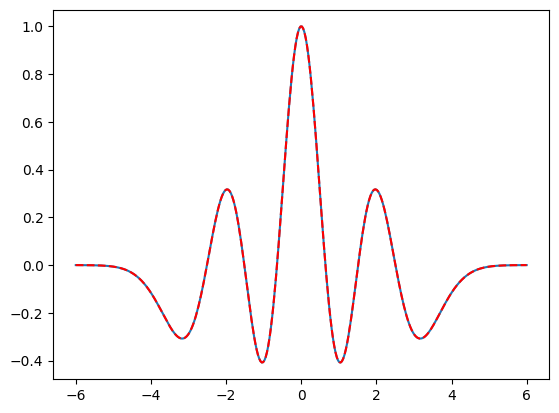

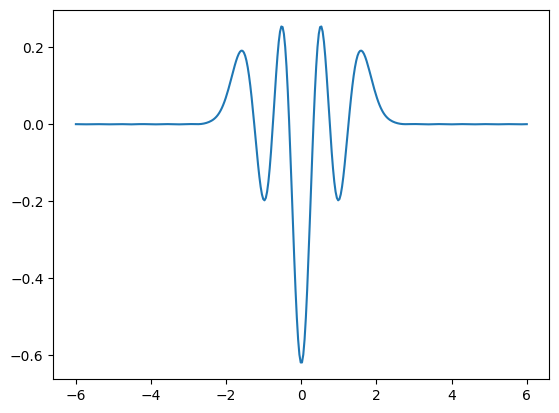

In [ ]:
def chi_number_state(n, eta):
    abs_eta2 = jnp.abs(eta)**2
    return jnp.exp(-0.5 * abs_eta2) * eval_laguerre(n, abs_eta2)



plt.plot(alphas, chi_number_state(n, alphas))

psi_number = jnp.zeros(N_max, dtype=jnp.complex128).at[n].set(1.0)
C = characteristic_function_pure(psi_number)

# psi_coherent = coherent_state(jnp.sqrt(10), N_max=N_max)
# C = characteristic_function_pure(psi_coherent)

# C = characteristic_function_mixed(rho_th)
# W_thermal = wigner_function(1.0, C_thermal)


data = []

plt.plot(alphas, C(jnp.array([alphas]))[0], "r--")
plt.show()

# @jax.remat
def scan_fn(_, alpha):
    value = wigner_function(alpha, C, 100, 5.0)
    # value = jax.lax.stop_gradient(wigner_function(alpha, C, 200, jnp.sqrt(N_max/2)))
    return None, value

_, wigner_vals = jax.lax.scan(scan_fn, init=None, xs=alphas)

plt.plot(alphas, wigner_vals)

# for alpha in alphas:
#     print(alpha)
#     data.append(wigner_function(alpha, C))

# plt.plot(data)


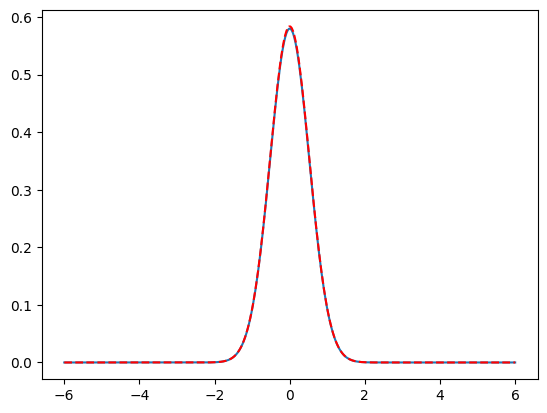

In [22]:
C = characteristic_function_mixed(rho_th)

@jax.remat
def scan_fn(_, alpha):
    # value = wigner_function(alpha, C, 100, 5.0)
    value = wigner_function(alpha, C, 300, jnp.sqrt(N_max/2))
    return None, value

_, wigner_vals = jax.lax.scan(scan_fn, init=None, xs=alphas)
plt.plot(alphas, wigner_vals)

_n = jnp.arange(rho_th.shape[0])
# n_bar = jnp.sum(_n * jnp.diag(rho_th))
n_bar = 1 / (jnp.exp(h_bar * 2 * jnp.pi * f * (1/(Boltzmann*temperature))) - 1)
wigner_vals_theory = 2/ (jnp.pi*(2*n_bar+1))*jnp.exp(-2*jnp.abs(alphas)**2 / (2*n_bar + 1))
plt.plot(alphas, wigner_vals_theory, "r--")

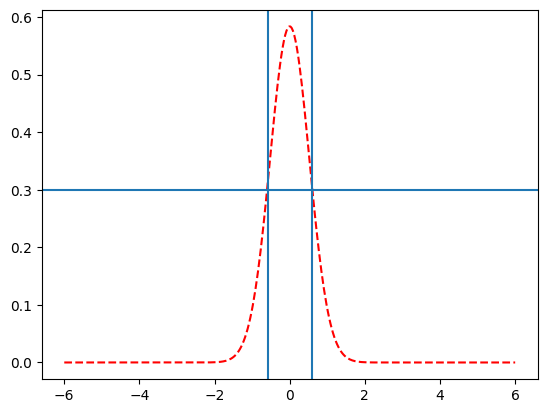

In [33]:
plt.plot(alphas, wigner_vals_theory, "r--")
plt.axvline( 0.5*(2.355*jnp.sqrt(h_bar/2)))
plt.axvline(-0.5*(2.355*jnp.sqrt(h_bar/2)))
plt.axhline(0.3)

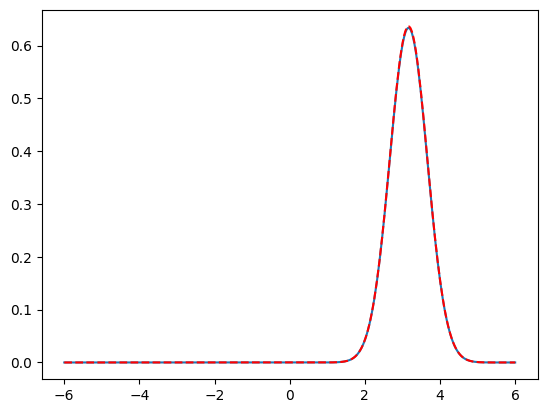

In [11]:
from simphony.simulation.jax_tools import python_based_scan
psi_coherent = coherent_state(jnp.sqrt(10), N_max=N_max)
C = characteristic_function_pure(psi_coherent)

# @jax.remat
def scan_fn(_, alpha):
    # value = wigner_function(alpha, C, 100, 5.0)
    value = jax.lax.stop_gradient(wigner_function(alpha, C, 450, jnp.sqrt(N_max/2)))
    return None, value

# _, wigner_vals = python_based_scan(scan_fn, init=None, xs=alphas)
_, wigner_vals = jax.lax.scan(scan_fn, init=None, xs=alphas)
plt.plot(alphas, wigner_vals)

wigner_vals_theory = 2/jnp.pi*jnp.exp(-2*jnp.abs(alphas-jnp.sqrt(10))**2)
plt.plot(alphas, wigner_vals_theory, "r--")


In [ ]:
data

In [ ]:
100

# # Grid
# x = jnp.linspace(-5, 5, 200)
# y = jnp.linspace(-5, 5, 200)
# eta_grid = x[:, None] + 1j * y[None, :]
# chi_grid = chi_number_state(n, eta_grid)  # Try n = 3

# plt.imshow(jnp.real(chi_grid), extent=[-5, 5, -5, 5], origin="lower")
# plt.title(f"Re[χₙ(η)] for n={n}")
# plt.colorbar()
# plt.show()


In [ ]:
def g2(t1, t2, rho, f=1.0, N_max=10):
    a_t1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_t2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    a_dag_t1 = jnp.conj(a_t1.T)
    a_dag_t2 = jnp.conj(a_t2.T)

    numerator = expectation_value_mixed(a_dag_t1 @ a_dag_t2 @ a_t2 @ a_t1, rho)
    print(numerator)
    denominator = (
        expectation_value_mixed(a_dag_t1 @ a_t1, rho)
        * expectation_value_mixed(a_dag_t2 @ a_t2, rho)
    )

    return numerator / denominator

rho = thermal_state(N_max=10, f=1.0, temperature=1.0)
g2(0, 0, rho_th, f=1, N_max=N_max)

In [ ]:
jnp.exp(-h_bar*2*jnp.pi)

In [ ]:
N_max = 10
psi = jnp.zeros(N_max)
psi = psi.at[0].set(0.0)
psi = psi.at[1].set(1.0)
psi = psi/jnp.linalg.norm(psi)

E_hat = electric_field_operator()


In [ ]:
print(expectation_value_pure(E_hat, psi))
print(expectation_value_pure(E_hat@E_hat, psi))

In [ ]:
rho = jnp.outer(psi, jnp.conj(psi))
print(expectation_value_mixed(E_hat, rho))
print(expectation_value_mixed(E_hat@E_hat, rho))

In [ ]:
N_max = 10
# Construct annihilation operator matrix


# Example state: |3> = [0, 0, 0, 1, 0, ..., 0]
psi = jnp.zeros(N_max)
psi[2] = 1.0

a_0 = annihilation_operator(N_max=N_max)
# Apply annihilation operator
phi = a_0 @ psi

print("Resulting state amplitudes:", phi)

In [ ]:
a

In [ ]:
import jax
import jax.numpy as jnp
from scipy.constants import epsilon_0, Boltzmann

h_bar = 0.5

def annihilation_operator(N_max=10, f=1, t=0):
    a = jnp.zeros((N_max, N_max), dtype=jnp.complex128)
    for n in range(1, N_max):
        a = a.at[n-1, n].set(jnp.sqrt(n))
    
    # return a*jnp.exp(-1j*2*jnp.pi*f*t)
    return a

def electric_field_operator(N_max=10, f=1, t=0, mode_volume=1):
    E_0 = jnp.sqrt((h_bar*2*jnp.pi*f)/(epsilon_0*mode_volume))
    E_0 = 1
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    
    return E_0 * (a + a_dagger)

def number_operator(N_max, f=1.0, t=0):
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    return a_dagger@a

def expectation_value_pure(operator, psi):
    return jnp.vdot(psi, operator@psi)

def expectation_value_mixed(operator, rho):
    return jnp.trace(rho@operator)

def thermal_state(N_max, f=1.0, temperature=1/Boltzmann):
    n = jnp.arange(0, N_max)
    E_n = h_bar*2*jnp.pi*f*(n+0.5)
    
    P_n = jnp.exp(-E_n / (Boltzmann*temperature))
    P_n = P_n / jnp.sum(P_n)
    return jnp.diag(P_n)

def coherent_state(alpha, N_max=10, f=1.0):
    n = jnp.arange(0, N_max)
    return jnp.exp(-0.5*jnp.abs(alpha)**2) * alpha**n / jnp.sqrt(jax.scipy.special.factorial(n))

def vacuum_state(N_max=10, f=1.0):
    vac = jnp.zeros(N_max, dtype=jnp.complex128)
    vac = vac.at[0].set(1.0)
    return vac

def displacement_operator(alpha, N_max=10, f=1.0, t=0):
    a = annihilation_operator(N_max=N_max, f=f, t=t)
    a_dagger = jnp.conj(a.T)
    return jax.scipy.linalg.expm(alpha*a_dagger - jnp.conj(alpha)*a)

# def characteristic_function_mixed(rho, f=1.0, t=0):
#     N_max = rho.shape[0]
#     def characteristic_fn(eta):
#         return jnp.trace(rho@displacement_operator(eta, N_max=N_max, f=f, t=t))    
    
#     return jax.vmap(jax.vmap(characteristic_fn))

def characteristic_function_mixed(rho, f=1.0, t=0):
    N_max = rho.shape[0]

    def characteristic_fn(eta):
        return jnp.trace(rho @ displacement_operator(eta, N_max=N_max, f=f, t=t))

    def apply_fn(eta_grid):  # eta_grid shape: (N, M)
        flat_eta = eta_grid.reshape(-1)

        def scan_fn(carry, eta):
            val = characteristic_fn(eta)
            return carry, val

        # remat helps prevent backprop memory buildup
        _, results = jax.lax.scan(jax.remat(scan_fn), None, flat_eta)
        return results.reshape(eta_grid.shape)

    return apply_fn

# def characteristic_function_mixed(rho, f=1.0, t=0):
#     N_max = rho.shape[0]

#     @jax.remat
#     def characteristic_fn(eta):
#         return jnp.trace(rho @ displacement_operator(eta, N_max=N_max, f=f, t=t))

#     vectorized_fn = jax.vmap(characteristic_fn)

#     @jax.remat
#     def apply_fn(eta_grid):  # eta_grid shape: (N, M) complex
#         flat_eta = eta_grid.reshape(-1)
#         result = vectorized_fn(flat_eta)
#         return result.reshape(eta_grid.shape)

#     return apply_fn

def characteristic_function_pure(psi, f=1.0, t=0):
    rho = jnp.outer(psi, psi.conj().T)
    N_max = rho.shape[0]
    # def characteristic_fn(eta):
    #     return jnp.trace(rho@displacement_operator(eta, N_max=N_max, f=f, t=t))
    
    return characteristic_function_mixed(rho, f=f, t=t)

def characteristic_function_gaussian(mean, covariance):
    def characteristic_fn(eta):
        xi = jnp.sqrt(2) * jnp.array([jnp.real(eta), jnp.imag(eta)])
        return jax.scipy.linalg.expm(-0.5*xi@covariance@eta + 1j*mean@xi)
    
    return characteristic_fn

def eigenvalue_from_vector(A, v):
    Av = A @ v
    # Normalize vector to unit norm to avoid scaling ambiguity
    v_normalized = v / jnp.linalg.norm(v)
    return jnp.vdot(v_normalized, Av)  # = λ if v is an eigenvector

# @jax.jit
# def wigner_function(alpha, characteristic_fn, grid_size=100, limit=1.0):
#     # Discretize complex plane
#     dx = 2 * limit / grid_size
#     x = jnp.linspace(-limit, limit, grid_size)
#     y = jnp.linspace(-limit, limit, grid_size)
#     xx, yy = jnp.meshgrid(x, y)
#     lam = xx + 1j * yy
#     exponent = alpha * jnp.conj(lam) - jnp.conj(alpha) * lam
#     integrand = characteristic_fn(lam) * jnp.exp(exponent)
#     integral = jnp.sum(integrand) * (dx ** 2)

#     return (1 / jnp.pi**2) * integral.real

# @jax.jit(static_argnames=["characteristic_fn"])
def wigner_function(alpha, characteristic_fn, grid_size=80, limit=4.0):
    dx = 2 * limit / grid_size
    x = jnp.linspace(-limit, limit, grid_size)
    y = jnp.linspace(-limit, limit, grid_size)
    xx, yy = jnp.meshgrid(x, y)
    lam = xx + 1j * yy  # shape: (grid_size, grid_size)

    lam_flat = lam.reshape(-1)
    chi_vals = characteristic_fn(lam_flat).reshape(lam.shape)

    exponent = jnp.conj(lam) * alpha - lam * jnp.conj(alpha)
    integrand = chi_vals * jnp.exp(exponent)
    integral = jnp.sum(integrand) * dx**2

    return (1 / jnp.pi**2) * integral.real
# wigner_function = jax.jit(
#     wigner_function,
#     static_argnames=["characteristic_fn", "grid_size", "limit"]
# )

def coherence_1(rho, t1, t2):
    N_max = rho.shape[0]
    t1 = 0
    t2 = 1
    a_hat_1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_hat_2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    denominator = jnp.sqrt(
        expectation_value_mixed(a_hat_1.conj().T @ a_hat_1, rho)
        * expectation_value_mixed(a_hat_2.conj().T @ a_hat_2, rho)
    )
    
    numerator = expectation_value_mixed(a_hat_1.conj().T @ a_hat_2, rho)

    return numerator/denominator

def coherence_2(rho, t1, t2):
    N_max = rho.shape[0]
    a_hat_1 = annihilation_operator(N_max=N_max, f=f, t=t1)
    a_hat_2 = annihilation_operator(N_max=N_max, f=f, t=t2)
    denominator = (
        expectation_value_mixed(a_hat_1.conj().T @ a_hat_1, rho)
        * expectation_value_mixed(a_hat_2.conj().T @ a_hat_2, rho)
    )

    numerator = expectation_value_mixed(a_hat_1.conj().T @ a_hat_2.conj().T @ a_hat_2 @ a_hat_1, rho)

    return numerator/denominator
